In [1]:
!pip install matplotlib
import torch
import torch.nn.functional as F
import math
import torch.nn
import matplotlib.pyplot as plt
import numpy as np

/Users/ben/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def plot_tensor(tensor):
    fig, ax = plt.subplots()
    im = ax.imshow(tensor, cmap='viridis') # You can use other colormaps like 'plasma', 'inferno', 'magma', etc.
    plt.show()

class Register(object):
    def __init__(self, name, size):
        self.name = name
        self.size = size
        self.offset = None

class Embedding(object):
    def __init__(self, tokens: list[str], registers: list[Register]):
        self.tokens = tokens
        self.token_map = { t: i for i,t in enumerate(tokens) }
        self.registers = registers
        self.register_map = {}
        self.register_size = 0
        
        if len(registers) == 0 or registers[0].name != 'pos':
            raise Exception("First register must be 'pos'") 
        
        offset = len(tokens)
        for reg in registers:
            reg.offset = offset
            offset += reg.size
            self.register_size += reg.size
            self.register_map[reg.name] = reg
            
        self.dim = len(tokens) + self.register_size

    def tokenize(self, string: str):
        return F.one_hot(torch.tensor([self.token_map[c] for c in string]), num_classes=len(self.tokens)).float()

    def embed(self, sequence):
        # We want to create additional space to store the registers
        extension_tensor = torch.zeros(*sequence.shape[:-1], self.register_size)

        # Encode position in the first extra embedding dimension
        for i in range(sequence.shape[0]):
            extension_tensor[i, 0] = math.sin(i*(2*math.pi)/100)
            extension_tensor[i, 1] = math.cos(i*(2*math.pi)/100)

        sequence = torch.cat((sequence, extension_tensor), dim=-1)

        return sequence

class AttentionLayer(object):
    def __init__(self, instruction):
        self.instruction = instruction
        
    def attend(self, seq):
        query = seq @ self.instruction.query
        key = seq @ self.instruction.key
        value = seq @ self.instruction.value

        causal_mask = torch.triu(torch.ones(seq.shape[0], seq.shape[0]), diagonal=1)*-1e10
        norm = np.sqrt(seq.shape[-1])
        
        kq = torch.nn.Softmax(1)(query @ key.T / norm + causal_mask)
        print('attention query')
        #plot_tensor(query)
        #print('key')
        #plot_tensor(key)
        #plot_tensor(query @ key.T)
        plot_tensor(kq)
        #print(query @ key.T)
                    
        return (seq + kq @ value)
    
class MLPLayer(object):
    def __init__(self, instruction):
        self.instruction = instruction
        
    def forward(self, seq):
        return torch.nn.GELU()(seq @ self.instruction.first_weights + self.instruction.first_bias) @ self.instruction.second_weights + self.instruction.second_bias
      
tokens = list('0123456789+=!')
pos = Register('pos', 2)
plus_pos = Register('plus_pos', 2)
equal_pos = Register('equal_pos', 2)
left_digit = Register('left', len(tokens))
right_digit = Register('right', len(tokens))

embedding = Embedding(tokens, [pos, plus_pos, equal_pos, left_digit, right_digit])
        
class FindAndStore(object):
    def __init__(self, embedding: Embedding, token: str, register: Register):
        pos_reg = embedding.register_map['pos']
        
        # No matter the current token, we attend to if the attended token is the given token
        token_select = torch.zeros(embedding.dim, embedding.dim) - 1e10
        token_select[:, int(embedding.token_map[token])] = 1e10

        position_select = torch.zeros(embedding.dim, embedding.dim)
        position_select[pos_reg.offset, register.offset] = 1.0
        position_select[pos_reg.offset + 1, register.offset + 1] = 1.0
        
        self.key = torch.eye(embedding.dim)
        self.query = token_select
        self.value = position_select

ex = embedding.embed(embedding.tokenize('10+10=2111')) 
        
class GetRelativeToken(object):
    def __init__(self, embedding: Embedding, pos_reg: Register, steps: int, out: Register):
        tpos_reg = embedding.register_map['pos']
        
        position_select = torch.zeros(embedding.dim, embedding.dim)
        position_select[tpos_reg.offset, tpos_reg.offset] = 1e10
        position_select[tpos_reg.offset + 1, tpos_reg.offset + 1] = 1e10

        i = -steps
        sin = math.sin(i*(2*math.pi)/100)*1
        cos = math.cos(i*(2*math.pi)/100)*1

        rotation = torch.zeros(embedding.dim, embedding.dim)
        rotation[pos_reg.offset, tpos_reg.offset] = cos
        rotation[pos_reg.offset + 1, tpos_reg.offset] = -sin
        rotation[pos_reg.offset, tpos_reg.offset + 1] = sin
        rotation[pos_reg.offset + 1, tpos_reg.offset + 1] = cos
        #plot_tensor(rotation)
        
        token_copy = torch.zeros(embedding.dim, embedding.dim)
        for i in range(len(embedding.tokens)):
            token_copy[i, i + out.offset] = 1.0
            
        self.query = rotation
        self.key = position_select
        self.value = token_copy
                

attention query


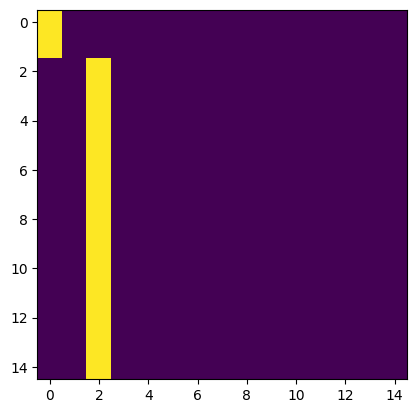

attention query


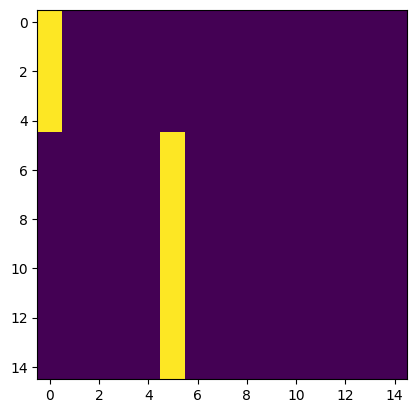

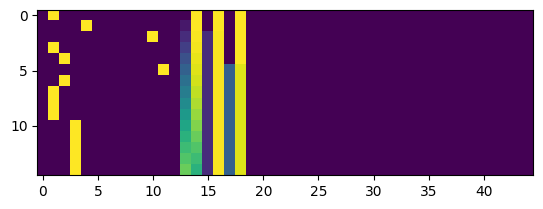

attention query


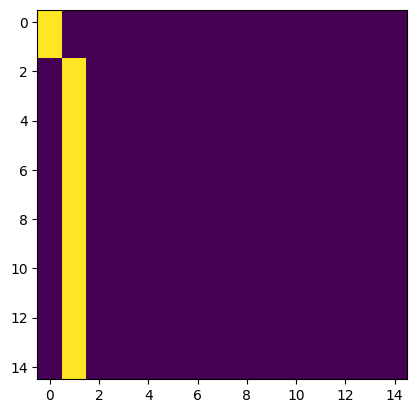

attention query


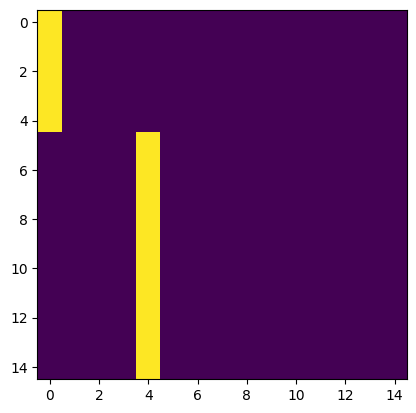

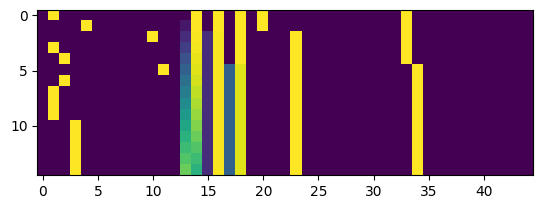

In [5]:
find_plus = AttentionLayer(FindAndStore(embedding, '+', plus_pos))
before_plus = AttentionLayer(GetRelativeToken(embedding, plus_pos, -1, left_digit))

find_equal = AttentionLayer(FindAndStore(embedding, '=', equal_pos))
before_equal = AttentionLayer(GetRelativeToken(embedding, equal_pos, -1, right_digit))

x = embedding.embed(embedding.tokenize('14+12=211133333'))
x = find_plus.attend(x)
x = find_equal.attend(x)
plot_tensor(x)

x = before_plus.attend(x)
x = before_equal.attend(x)

plot_tensor(x)
#x = distance_to_plus.attend(x)
#plot_tensor(x)